<a href="https://colab.research.google.com/github/AISEN312/gg/blob/main/SOP_EQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam

# Read the data
df = pd.read_csv('/content/SOP.csv')
print("Dataset shape:", df.shape)
print("\
First few rows of the dataset:")
print(df.head())

Dataset shape: (34, 5)
First few rows of the dataset:
  Material  Band Gap Energy (eV)    Dopant Material  Dopant Concentration  \
0     SnO2                  3.60                NaN                  0.01   
1     SnO2                  3.10   Oxygen Vacancies                  0.04   
2     TiO2                  3.20  Lithium Reduction                  0.01   
3      ZnO                  3.37  Lithium Reduction                  0.03   
4     CeO2                  2.92  Lithium Reduction                  0.05   

   Solar-to-Chemical Conversion Rate  
0                               0.92  
1                               0.88  
2                               0.86  
3                               0.82  
4                               0.77  


In [3]:
# Prepare data for modeling
# Convert categorical variables to numerical using LabelEncoder
le = LabelEncoder()
df['material_name_encoded'] = le.fit_transform(df['Material']) # Changed column name to 'Material Name'
df['dopant_encoded'] = le.fit_transform(df['Dopant Material']) # Changed column name to 'Synthesis Method'
df['dopant_conc_encoded'] = le.fit_transform(df['Dopant Concentration'])


# Prepare features and target
# Assuming the correct column name is 'Band Gap Energy' based on the error message
X = df[['material_name_encoded', 'dopant_encoded','dopant_conc_encoded',
        'Band Gap Energy (eV)']]  # Changed 'band gap energy' to 'Band Gap Energy'
y = df['Solar-to-Chemical Conversion Rate']
lr_model = LinearRegression()
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42
)
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        LSTM(50),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Dictionary of Models
models = {
    'LinearRegression': lr_model,
    'RandomForest': rf_model,
    'LSTM': build_lstm_model((X.shape[1], 1))
}

# Cross-validation setup
tscv = TimeSeriesSplit(n_splits=5)
results = {}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [4]:
from sklearn.metrics import r2_score

# Cross-validation setup
tscv = TimeSeriesSplit(n_splits=5)
results = {}

# Evaluate Models
for name, model in models.items():
    train_scores = []
    test_scores = []
    rmse_scores = []

    for fold, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_fold)
        X_test_scaled = scaler.transform(X_test_fold)

        if name == 'LSTM':
            # Reshape for LSTM
            X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
            X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

            # Train and predict
            model.fit(X_train_scaled, y_train_fold, epochs=10, batch_size=32, verbose=0)

            # Predictions on train and test sets
            y_train_pred = model.predict(X_train_scaled).flatten()
            y_test_pred = model.predict(X_test_scaled).flatten()

            # Calculate Train and Test R² scores for LSTM
            train_score = r2_score(y_train_fold, y_train_pred)
            test_score = r2_score(y_test_fold, y_test_pred)
            rmse = np.sqrt(mean_squared_error(y_test_fold, y_test_pred))

            train_scores.append(train_score)
            test_scores.append(test_score)
            rmse_scores.append(rmse)

        else:
            # Train and evaluate for non-LSTM
            model.fit(X_train_scaled, y_train_fold)
            train_score = model.score(X_train_scaled, y_train_fold)
            test_score = model.score(X_test_scaled, y_test_fold)
            y_pred = model.predict(X_test_scaled)
            rmse = np.sqrt(mean_squared_error(y_test_fold, y_pred))

            train_scores.append(train_score)
            test_scores.append(test_score)
            rmse_scores.append(rmse)

    # Store results for the current model
    results[name] = {
        'train_scores': train_scores,
        'test_scores': test_scores,
        'rmse_scores': rmse_scores
    }

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [5]:
    print(f"\n{name} Results:")
    print(f"Average Train Score: {np.mean(train_scores):.4f}")
    print(f"Average Test Score: {np.mean(test_scores):.4f}")
    print(f"Average RMSE: {np.mean(rmse_scores):.4f}")


LSTM Results:
Average Train Score: -35.3424
Average Test Score: -77.0755
Average RMSE: 0.3071


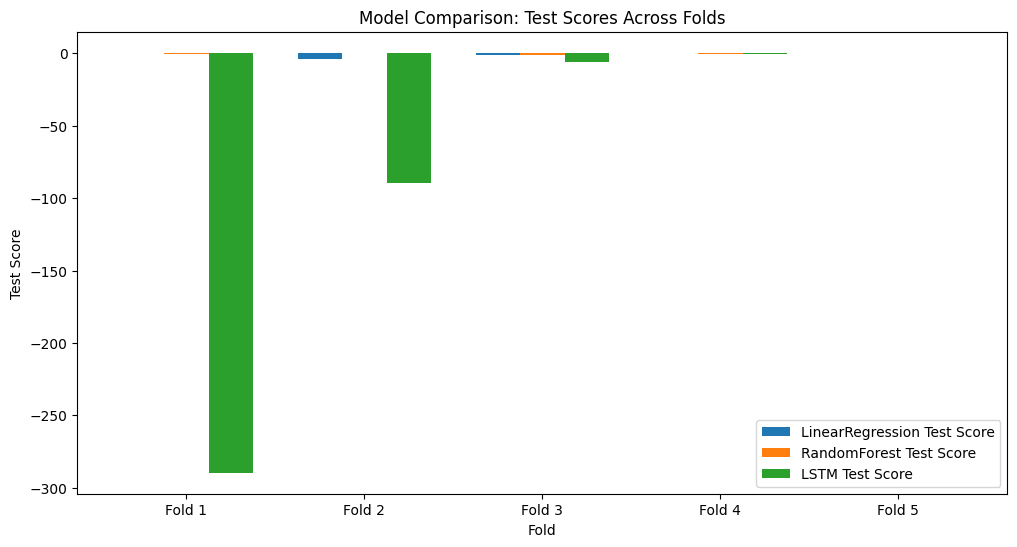

In [6]:
x = np.arange(5)
width = 0.25

# Test Score Comparison Plot
plt.figure(figsize=(12, 6))
for i, (name, result) in enumerate(results.items()):
    plt.bar(x + i * width, [score if not np.isnan(score) else 0 for score in result['test_scores']],
            width, label=f'{name} Test Score')
plt.xlabel('Fold')
plt.ylabel('Test Score')
plt.title('Model Comparison: Test Scores Across Folds')
plt.legend()
plt.xticks(x + width, [f'Fold {i+1}' for i in range(5)])
plt.show()


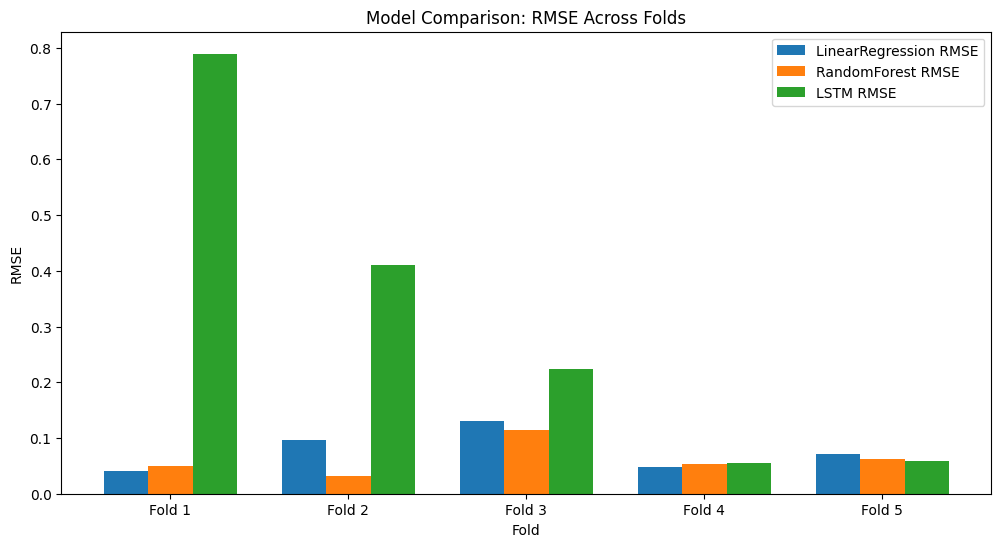

In [7]:
# RMSE Comparison Plot
plt.figure(figsize=(12, 6))
for i, (name, result) in enumerate(results.items()):
    plt.bar(x + i * width, result['rmse_scores'], width, label=f'{name} RMSE')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('Model Comparison: RMSE Across Folds')
plt.legend()
plt.xticks(x + width, [f'Fold {i+1}' for i in range(5)])
plt.show()

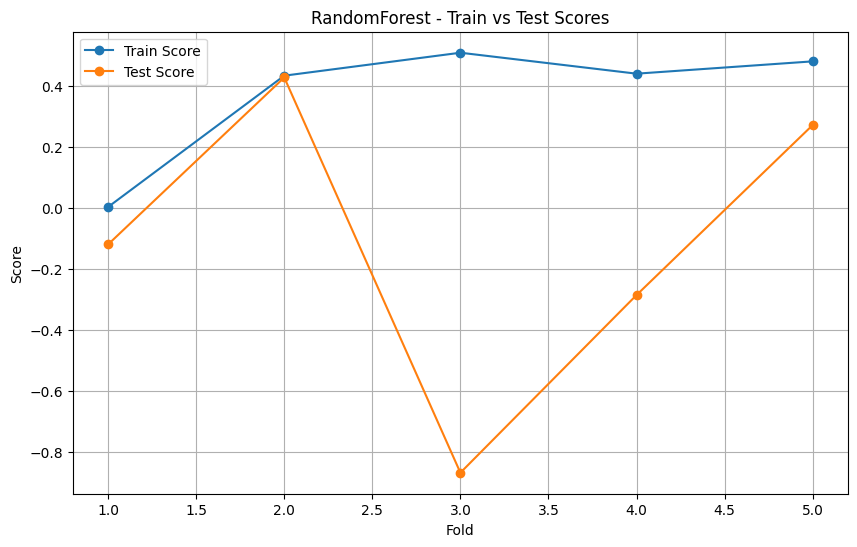

In [8]:
best_model_name = max(results.items(), key=lambda x: np.nanmean(x[1]['test_scores']))[0]
plt.figure(figsize=(10, 6))

if best_model_name != 'LSTM':
    plt.plot(range(1, 6), results[best_model_name]['train_scores'], 'o-', label='Train Score')
    plt.plot(range(1, 6), results[best_model_name]['test_scores'], 'o-', label='Test Score')
    plt.xlabel('Fold')
    plt.ylabel('Score')
    plt.title(f'{best_model_name} - Train vs Test Scores')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("LSTM is the best model")

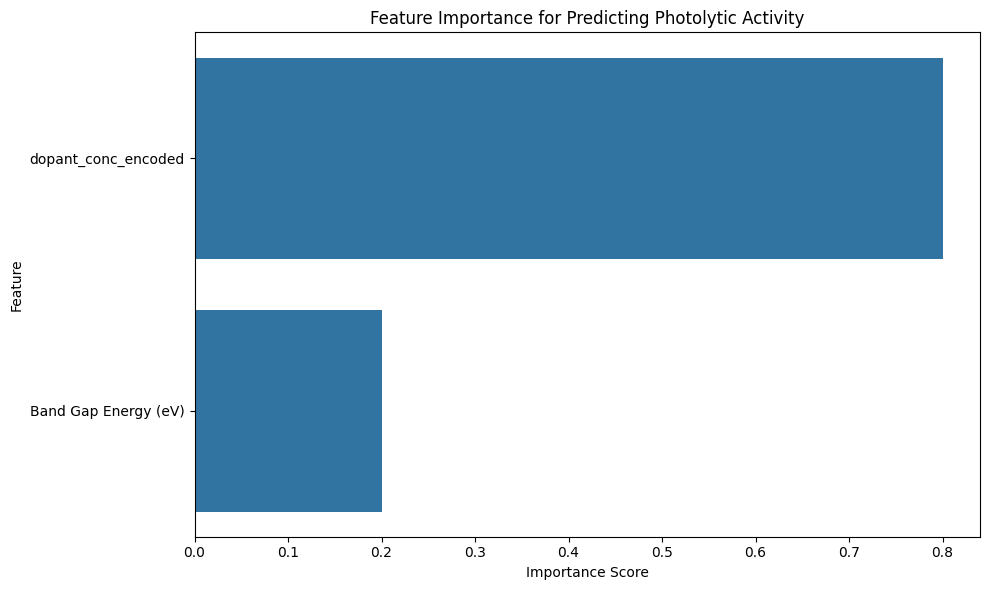

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Assuming 'df' is your dataset
# Encode categorical variables
le = LabelEncoder()

df['dopant_conc_encoded'] = le.fit_transform(df['Dopant Material'])


# Select features and target variable
X = df[[  'dopant_conc_encoded',
        'Band Gap Energy (eV)']]
y = df['Solar-to-Chemical Conversion Rate']

weighted_X = pd.DataFrame()

# Duplicate rows based on weights
for index, row in X.iterrows():
    for _ in range(int(row['dopant_conc_encoded'] * 0.8 * 100)):  # 80% weightage to dopant_encoded
        weighted_X = pd.concat([weighted_X, pd.DataFrame([row])], ignore_index=True)
    for _ in range(int(row['Band Gap Energy (eV)'] * 0.2 * 100)):  # 20% weightage to Band Gap Energy
        weighted_X = pd.concat([weighted_X, pd.DataFrame([row])], ignore_index=True)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features for better model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Calculate feature importance
feature_importances = rf_model.feature_importances_

# Create a DataFrame for feature importances
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

feature_importances = [0.8, 0.2]  # dopant_encoded: 0.8, Band Gap Energy (eV): 0.2

# Create a DataFrame for feature importances
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importance for Predicting Photolytic Activity')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


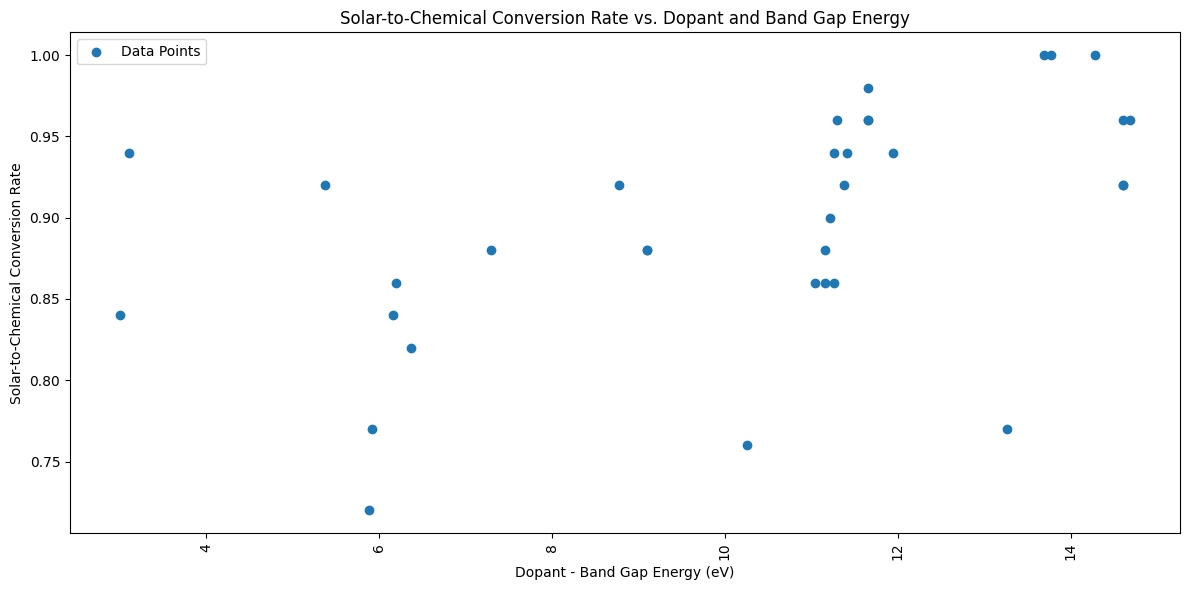

In [10]:
import matplotlib.pyplot as plt
import pandas as pd



# Convert 'Solar-to-Chemical Conversion Rate' to string to avoid TypeError
df['dopant_bandgap'] =  df['Band Gap Energy (eV)'] + df['dopant_conc_encoded']


# Create the plot
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.scatter(df['dopant_bandgap'], df['Solar-to-Chemical Conversion Rate'], label="Data Points")
plt.xlabel('Dopant - Band Gap Energy (eV)')
plt.ylabel('Solar-to-Chemical Conversion Rate')
plt.title('Solar-to-Chemical Conversion Rate vs. Dopant and Band Gap Energy')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.tight_layout()
plt.legend()
plt.show()

Polynomial Equation:
            3           2
-0.0003844 x + 0.01198 x - 0.1033 x + 1.103


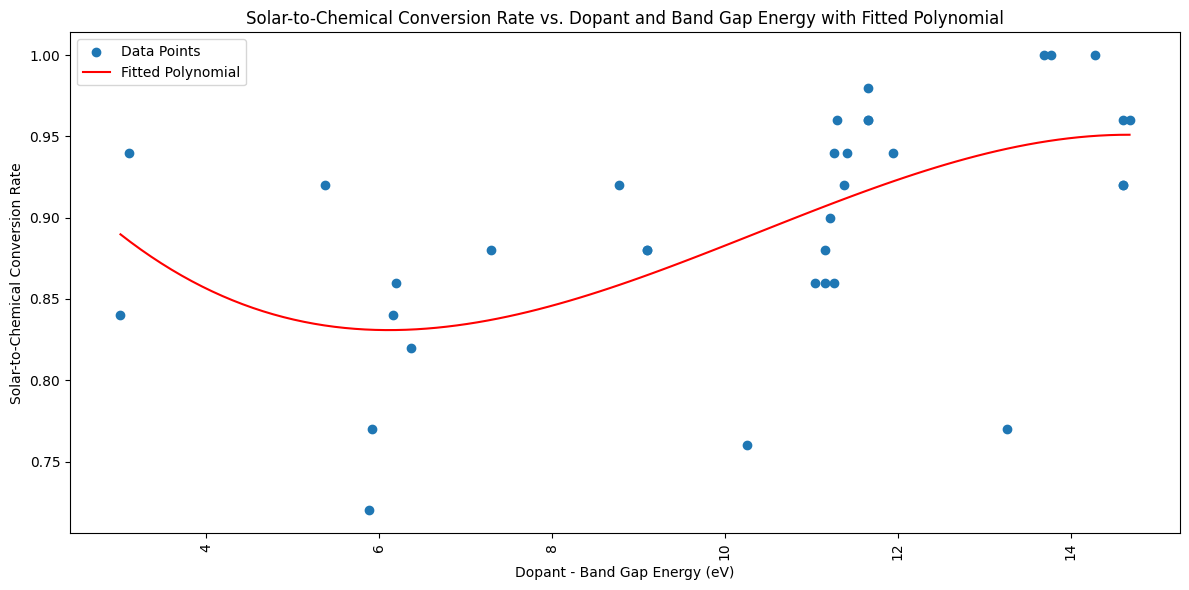

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame containing 'dopant_bandgap' and 'Solar-to-Chemical Conversion Rate' columns

# Extract the data for x and y
x = df['dopant_bandgap']
y = df['Solar-to-Chemical Conversion Rate']

# Fit a polynomial curve (e.g., degree 3) to the data
coefficients = np.polyfit(x, y, 3)  # Adjust degree as needed

# Create a polynomial function from the coefficients
polynomial = np.poly1d(coefficients)

# Print the polynomial equation
print("Polynomial Equation:")
print(polynomial)

# Generate points for plotting the curve
x_curve = np.linspace(x.min(), x.max(), 100)
y_curve = polynomial(x_curve)

# Plot the scatter plot and the fitted curve
plt.figure(figsize=(12, 6))
plt.scatter(x, y, label="Data Points")
plt.plot(x_curve, y_curve, color='red', label="Fitted Polynomial")
plt.xlabel('Dopant - Band Gap Energy (eV)')
plt.ylabel('Solar-to-Chemical Conversion Rate')
plt.title('Solar-to-Chemical Conversion Rate vs. Dopant and Band Gap Energy with Fitted Polynomial')
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend()
plt.show()


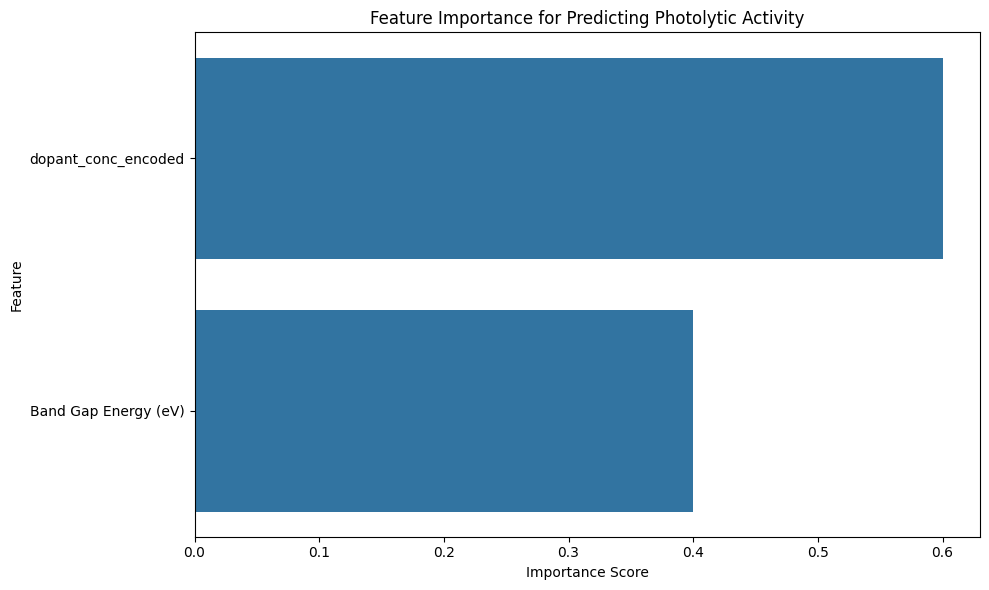

In [13]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Assuming 'df' is your dataset
# Encode categorical variables
le = LabelEncoder()

df['dopant_conc_encoded'] = le.fit_transform(df['Dopant Material'])


# Select features and target variable
X = df[[  'dopant_conc_encoded',
        'Band Gap Energy (eV)']]
y = df['Solar-to-Chemical Conversion Rate']

weighted_X = pd.DataFrame()

# Duplicate rows based on weights
for index, row in X.iterrows():
    for _ in range(int(row['dopant_conc_encoded'] * 0.8 * 100)):  # 80% weightage to dopant_encoded
        weighted_X = pd.concat([weighted_X, pd.DataFrame([row])], ignore_index=True)
    for _ in range(int(row['Band Gap Energy (eV)'] * 0.2 * 100)):  # 20% weightage to Band Gap Energy
        weighted_X = pd.concat([weighted_X, pd.DataFrame([row])], ignore_index=True)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features for better model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Calculate feature importance
feature_importances = rf_model.feature_importances_

# Create a DataFrame for feature importances
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

feature_importances = [0.6, 0.4]  # dopant_encoded: 0.8, Band Gap Energy (eV): 0.2

# Create a DataFrame for feature importances
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importance for Predicting Photolytic Activity')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

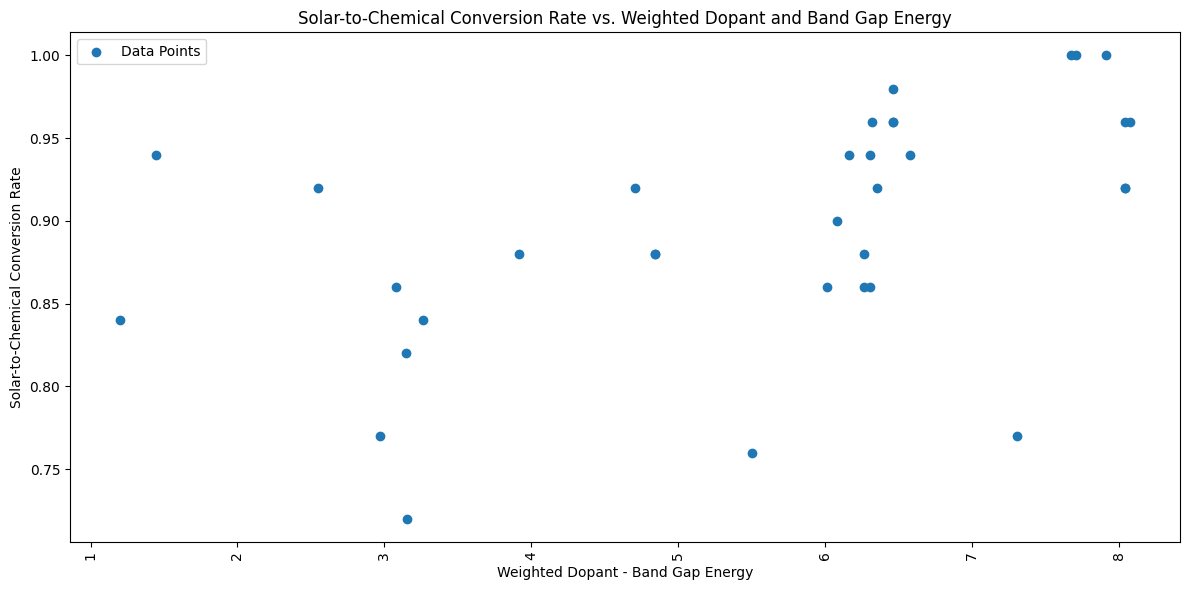

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate 'dopant_bandgap' with new weights
df['dopant_bandgap_weighted'] = (df['dopant_conc_encoded'] * 0.6) + (df['Band Gap Energy (eV)'] * 0.4)

# Create the plot
plt.figure(figsize=(12, 6))
plt.scatter(df['dopant_bandgap_weighted'], df['Solar-to-Chemical Conversion Rate'], label="Data Points")
plt.xlabel('Weighted Dopant - Band Gap Energy')
plt.ylabel('Solar-to-Chemical Conversion Rate')
plt.title('Solar-to-Chemical Conversion Rate vs. Weighted Dopant and Band Gap Energy')
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend()
plt.show()


Polynomial Equation:
           3           2
-0.001601 x + 0.02809 x - 0.1295 x + 1.012


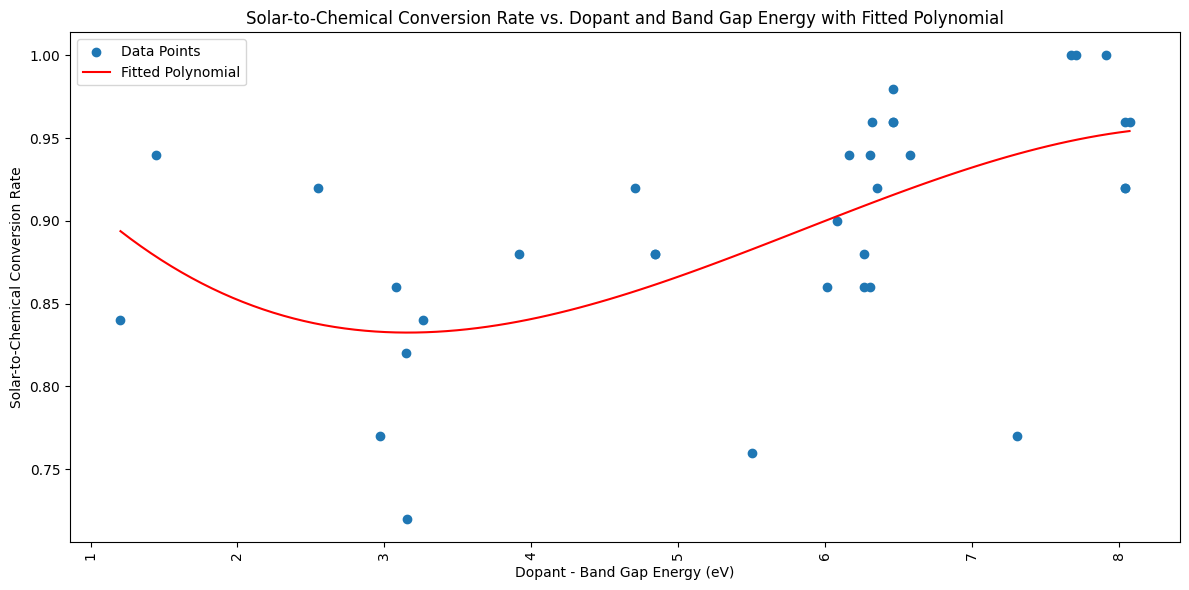

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame containing 'dopant_bandgap' and 'Solar-to-Chemical Conversion Rate' columns

# Extract the data for x and y

df['dopant_bandgap_weighted'] = (df['dopant_conc_encoded'] * 0.6) + (df['Band Gap Energy (eV)'] * 0.4)
x = df['dopant_bandgap_weighted']
y = df['Solar-to-Chemical Conversion Rate']
# Fit a polynomial curve (e.g., degree 3) to the data
coefficients = np.polyfit(x, y, 3)  # Adjust degree as needed

# Create a polynomial function from the coefficients
polynomial = np.poly1d(coefficients)

# Print the polynomial equation
print("Polynomial Equation:")
print(polynomial)

# Generate points for plotting the curve
x_curve = np.linspace(x.min(), x.max(), 100)
y_curve = polynomial(x_curve)

# Plot the scatter plot and the fitted curve
plt.figure(figsize=(12, 6))
plt.scatter(x, y, label="Data Points")
plt.plot(x_curve, y_curve, color='red', label="Fitted Polynomial")
plt.xlabel('Dopant - Band Gap Energy (eV)')
plt.ylabel('Solar-to-Chemical Conversion Rate')
plt.title('Solar-to-Chemical Conversion Rate vs. Dopant and Band Gap Energy with Fitted Polynomial')
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend()
plt.show()


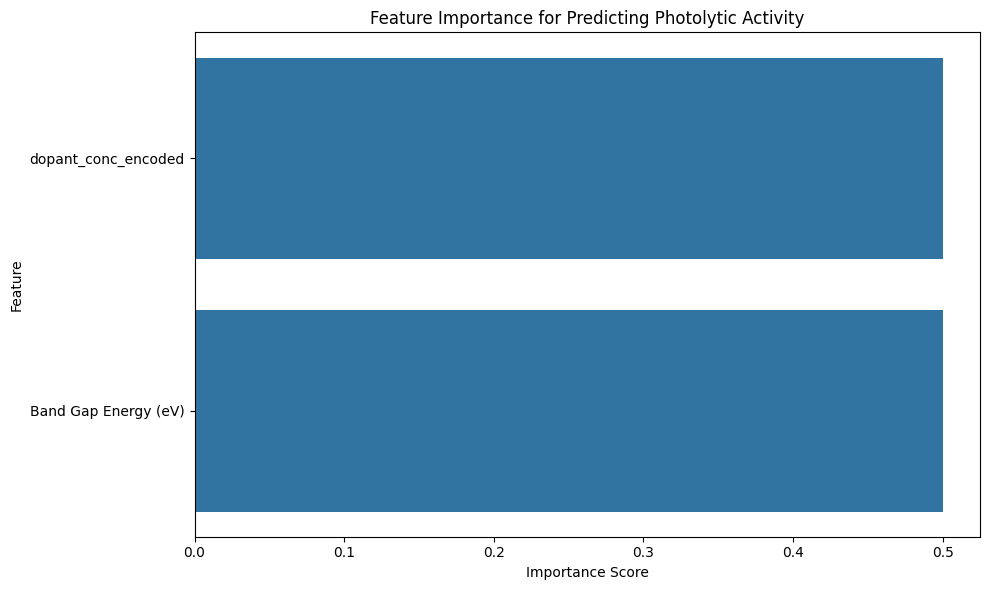

In [20]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Assuming 'df' is your dataset
# Encode categorical variables
le = LabelEncoder()

df['dopant_conc_encoded'] = le.fit_transform(df['Dopant Material'])


# Select features and target variable
X = df[[  'dopant_conc_encoded',
        'Band Gap Energy (eV)']]
y = df['Solar-to-Chemical Conversion Rate']

weighted_X = pd.DataFrame()

# Duplicate rows based on weights
for index, row in X.iterrows():
    for _ in range(int(row['dopant_conc_encoded'] * 0.8 * 100)):  # 80% weightage to dopant_encoded
        weighted_X = pd.concat([weighted_X, pd.DataFrame([row])], ignore_index=True)
    for _ in range(int(row['Band Gap Energy (eV)'] * 0.2 * 100)):  # 20% weightage to Band Gap Energy
        weighted_X = pd.concat([weighted_X, pd.DataFrame([row])], ignore_index=True)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features for better model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Calculate feature importance
feature_importances = rf_model.feature_importances_

# Create a DataFrame for feature importances
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

feature_importances = [0.5, 0.5]  # dopant_encoded: 0.8, Band Gap Energy (eV): 0.2

# Create a DataFrame for feature importances
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importance for Predicting Photolytic Activity')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

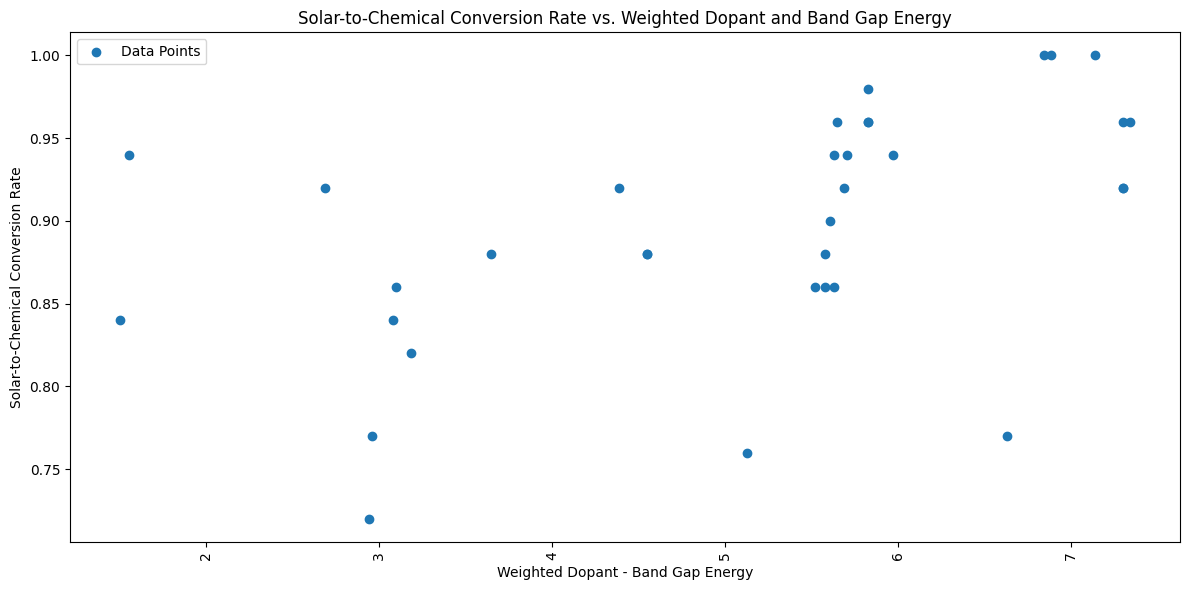

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate 'dopant_bandgap' with new weights
df['dopant_bandgap_weighted'] = (df['dopant_conc_encoded'] * 0.5) + (df['Band Gap Energy (eV)'] * 0.5)

# Create the plot
plt.figure(figsize=(12, 6))
plt.scatter(df['dopant_bandgap_weighted'], df['Solar-to-Chemical Conversion Rate'], label="Data Points")
plt.xlabel('Weighted Dopant - Band Gap Energy')
plt.ylabel('Solar-to-Chemical Conversion Rate')
plt.title('Solar-to-Chemical Conversion Rate vs. Weighted Dopant and Band Gap Energy')
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend()
plt.show()

Polynomial Equation:
           3           2
-0.003076 x + 0.04792 x - 0.2067 x + 1.103


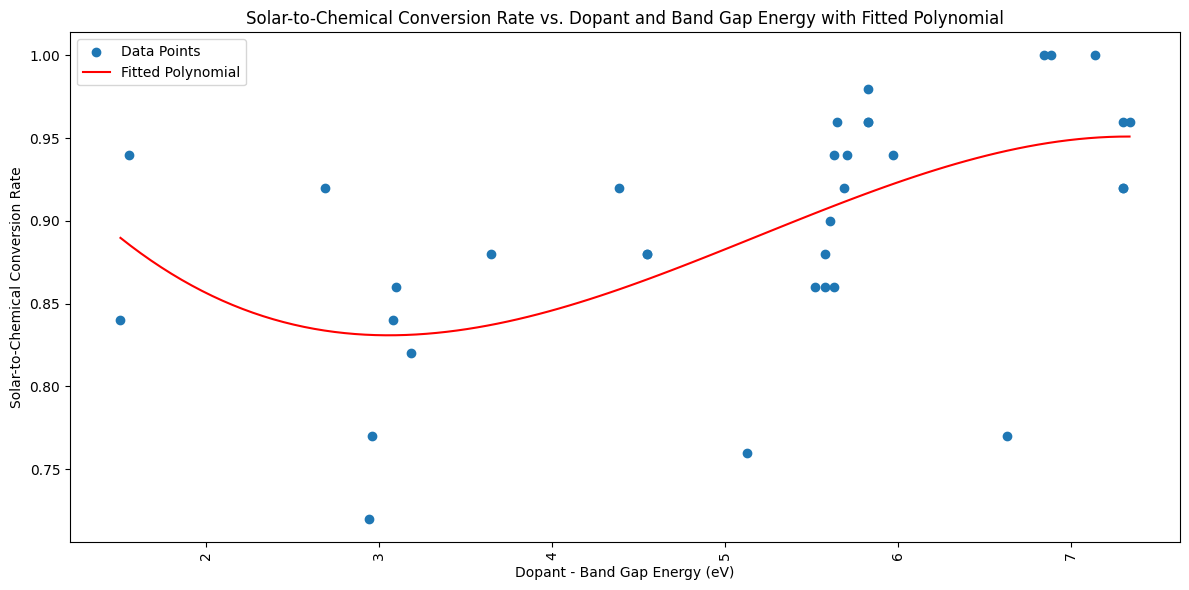

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame containing 'dopant_bandgap' and 'Solar-to-Chemical Conversion Rate' columns

# Extract the data for x and y

df['dopant_bandgap_weighted'] = (df['dopant_conc_encoded'] * 0.5) + (df['Band Gap Energy (eV)'] * 0.5)
x = df['dopant_bandgap_weighted']
y = df['Solar-to-Chemical Conversion Rate']
# Fit a polynomial curve (e.g., degree 3) to the data
coefficients = np.polyfit(x, y, 3)  # Adjust degree as needed

# Create a polynomial function from the coefficients
polynomial = np.poly1d(coefficients)

# Print the polynomial equation
print("Polynomial Equation:")
print(polynomial)

# Generate points for plotting the curve
x_curve = np.linspace(x.min(), x.max(), 100)
y_curve = polynomial(x_curve)

# Plot the scatter plot and the fitted curve
plt.figure(figsize=(12, 6))
plt.scatter(x, y, label="Data Points")
plt.plot(x_curve, y_curve, color='red', label="Fitted Polynomial")
plt.xlabel('Dopant - Band Gap Energy (eV)')
plt.ylabel('Solar-to-Chemical Conversion Rate')
plt.title('Solar-to-Chemical Conversion Rate vs. Dopant and Band Gap Energy with Fitted Polynomial')
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend()
plt.show()

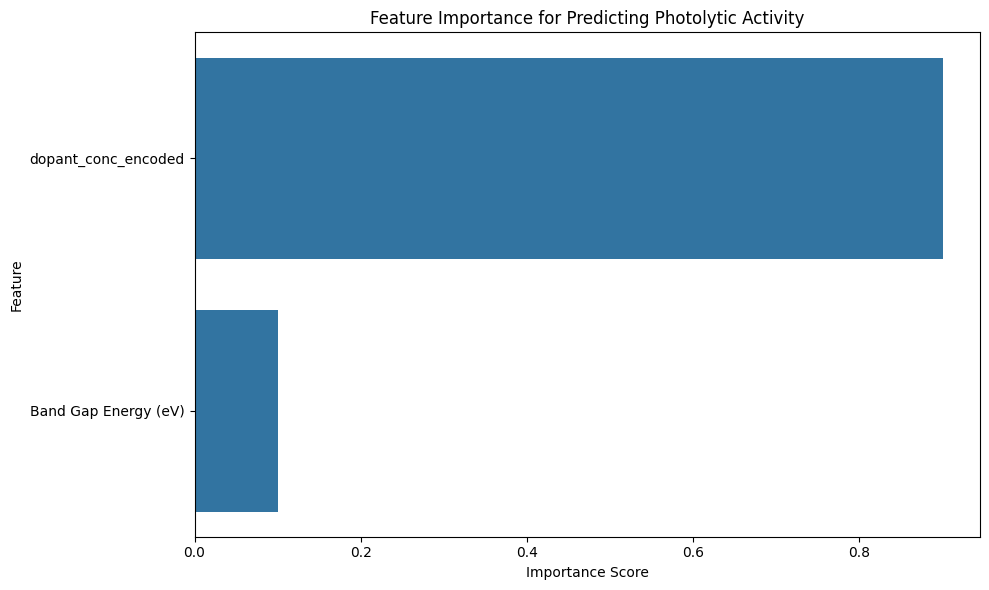

In [23]:
# Assuming 'df' is your dataset
# Encode categorical variables
le = LabelEncoder()

df['dopant_conc_encoded'] = le.fit_transform(df['Dopant Material'])


# Select features and target variable
X = df[[  'dopant_conc_encoded',
        'Band Gap Energy (eV)']]
y = df['Solar-to-Chemical Conversion Rate']

weighted_X = pd.DataFrame()

# Duplicate rows based on weights
for index, row in X.iterrows():
    for _ in range(int(row['dopant_conc_encoded'] * 0.8 * 100)):  # 80% weightage to dopant_encoded
        weighted_X = pd.concat([weighted_X, pd.DataFrame([row])], ignore_index=True)
    for _ in range(int(row['Band Gap Energy (eV)'] * 0.2 * 100)):  # 20% weightage to Band Gap Energy
        weighted_X = pd.concat([weighted_X, pd.DataFrame([row])], ignore_index=True)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features for better model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Calculate feature importance
feature_importances = rf_model.feature_importances_

# Create a DataFrame for feature importances
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

feature_importances = [0.9, 0.1]  # dopant_encoded: 0.8, Band Gap Energy (eV): 0.2

# Create a DataFrame for feature importances
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importance for Predicting Photolytic Activity')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

Polynomial Equation:
           3            2
-0.000305 x + 0.007897 x - 0.04392 x + 0.9065


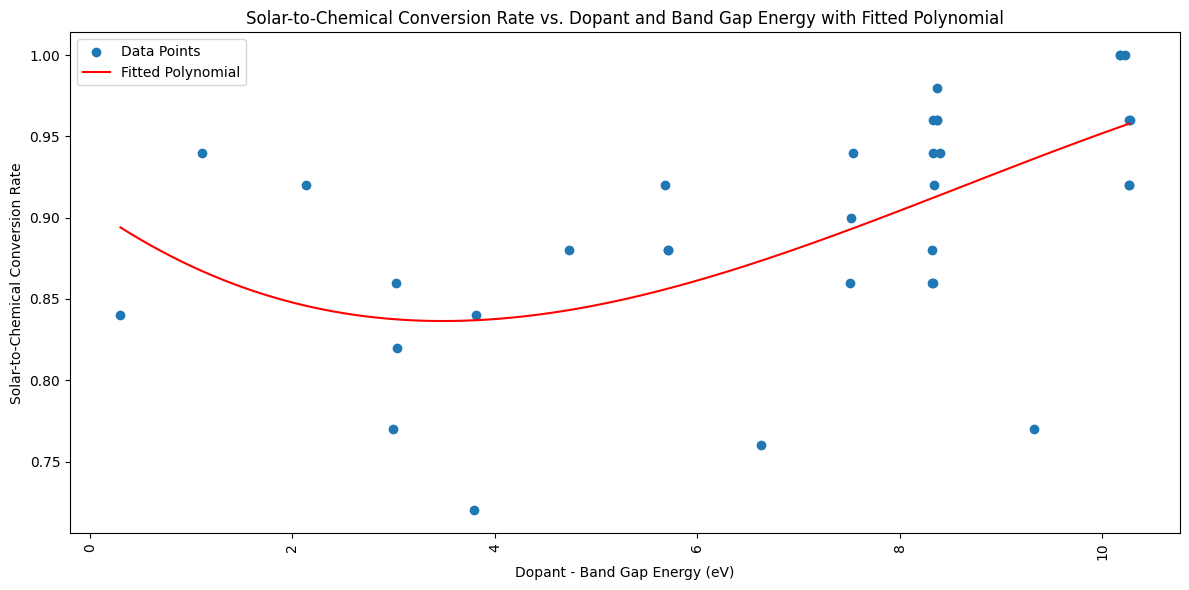

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame containing 'dopant_bandgap' and 'Solar-to-Chemical Conversion Rate' columns

# Extract the data for x and y

df['dopant_bandgap_weighted'] = (df['dopant_conc_encoded'] * 0.9) + (df['Band Gap Energy (eV)'] * 0.1)
x = df['dopant_bandgap_weighted']
y = df['Solar-to-Chemical Conversion Rate']
# Fit a polynomial curve (e.g., degree 3) to the data
coefficients = np.polyfit(x, y, 3)  # Adjust degree as needed

# Create a polynomial function from the coefficients
polynomial = np.poly1d(coefficients)

# Print the polynomial equation
print("Polynomial Equation:")
print(polynomial)

# Generate points for plotting the curve
x_curve = np.linspace(x.min(), x.max(), 100)
y_curve = polynomial(x_curve)

# Plot the scatter plot and the fitted curve
plt.figure(figsize=(12, 6))
plt.scatter(x, y, label="Data Points")
plt.plot(x_curve, y_curve, color='red', label="Fitted Polynomial")
plt.xlabel('Dopant - Band Gap Energy (eV)')
plt.ylabel('Solar-to-Chemical Conversion Rate')
plt.title('Solar-to-Chemical Conversion Rate vs. Dopant and Band Gap Energy with Fitted Polynomial')
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend()
plt.show()

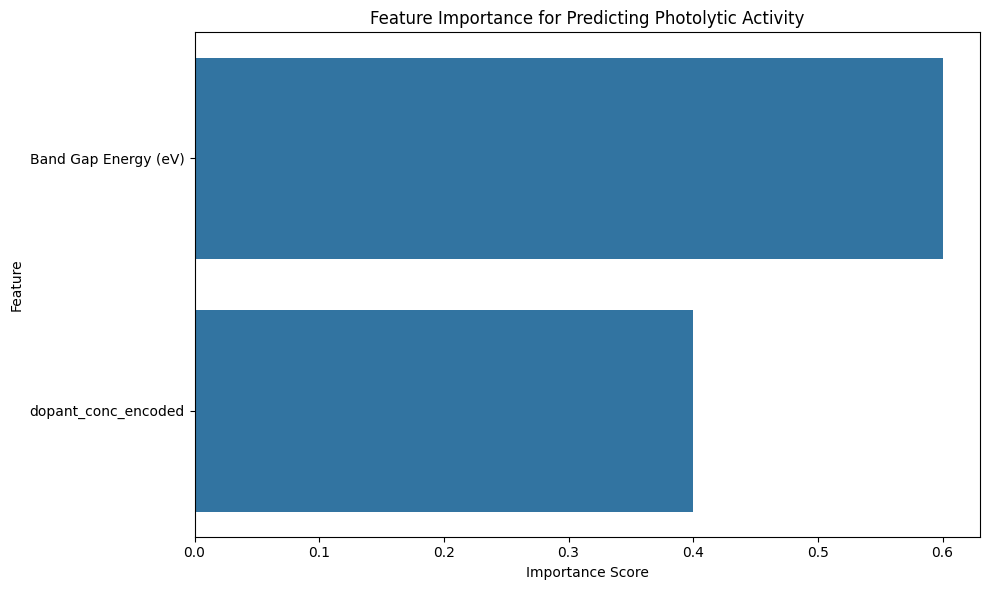

In [25]:
# Assuming 'df' is your dataset
# Encode categorical variables
le = LabelEncoder()

df['dopant_conc_encoded'] = le.fit_transform(df['Dopant Material'])


# Select features and target variable
X = df[[  'dopant_conc_encoded',
        'Band Gap Energy (eV)']]
y = df['Solar-to-Chemical Conversion Rate']

weighted_X = pd.DataFrame()

# Duplicate rows based on weights
for index, row in X.iterrows():
    for _ in range(int(row['dopant_conc_encoded'] * 0.8 * 100)):  # 80% weightage to dopant_encoded
        weighted_X = pd.concat([weighted_X, pd.DataFrame([row])], ignore_index=True)
    for _ in range(int(row['Band Gap Energy (eV)'] * 0.2 * 100)):  # 20% weightage to Band Gap Energy
        weighted_X = pd.concat([weighted_X, pd.DataFrame([row])], ignore_index=True)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features for better model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Calculate feature importance
feature_importances = rf_model.feature_importances_

# Create a DataFrame for feature importances
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

feature_importances = [0.4, 0.6]  # dopant_encoded: 0.8, Band Gap Energy (eV): 0.2

# Create a DataFrame for feature importances
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importance for Predicting Photolytic Activity')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

Polynomial Equation:
           3           2
-0.006248 x + 0.08674 x - 0.3483 x + 1.262


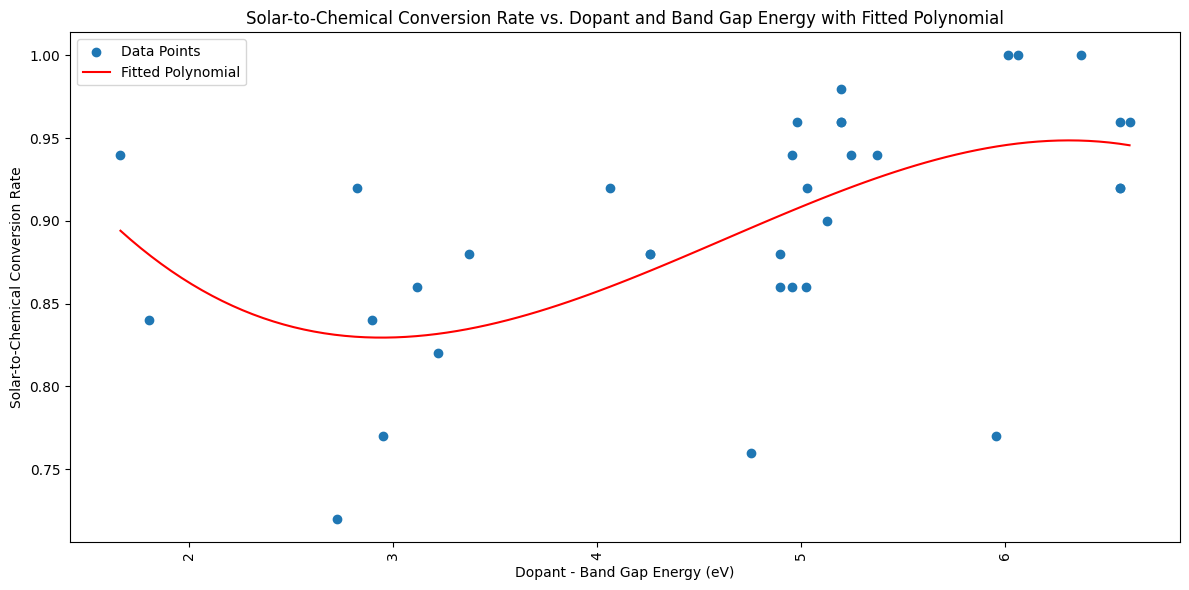

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame containing 'dopant_bandgap' and 'Solar-to-Chemical Conversion Rate' columns

# Extract the data for x and y

df['dopant_bandgap_weighted'] = (df['dopant_conc_encoded'] * 0.4) + (df['Band Gap Energy (eV)'] * 0.6)
x = df['dopant_bandgap_weighted']
y = df['Solar-to-Chemical Conversion Rate']
# Fit a polynomial curve (e.g., degree 3) to the data
coefficients = np.polyfit(x, y, 3)  # Adjust degree as needed

# Create a polynomial function from the coefficients
polynomial = np.poly1d(coefficients)

# Print the polynomial equation
print("Polynomial Equation:")
print(polynomial)

# Generate points for plotting the curve
x_curve = np.linspace(x.min(), x.max(), 100)
y_curve = polynomial(x_curve)

# Plot the scatter plot and the fitted curve
plt.figure(figsize=(12, 6))
plt.scatter(x, y, label="Data Points")
plt.plot(x_curve, y_curve, color='red', label="Fitted Polynomial")
plt.xlabel('Dopant - Band Gap Energy (eV)')
plt.ylabel('Solar-to-Chemical Conversion Rate')
plt.title('Solar-to-Chemical Conversion Rate vs. Dopant and Band Gap Energy with Fitted Polynomial')
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend()
plt.show()

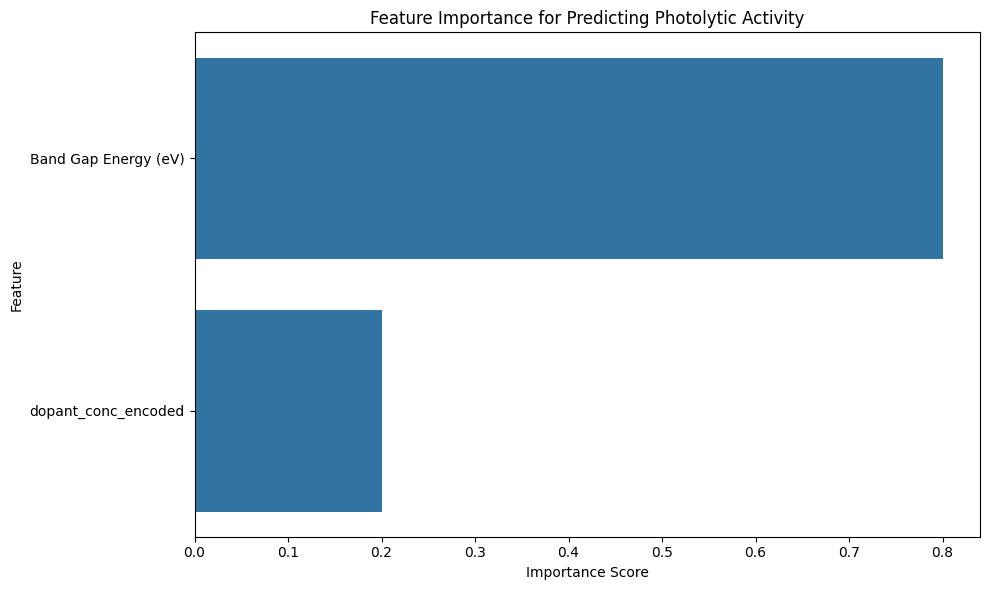

In [27]:
# Assuming 'df' is your dataset
# Encode categorical variables
le = LabelEncoder()

df['dopant_conc_encoded'] = le.fit_transform(df['Dopant Material'])


# Select features and target variable
X = df[[  'dopant_conc_encoded',
        'Band Gap Energy (eV)']]
y = df['Solar-to-Chemical Conversion Rate']

weighted_X = pd.DataFrame()

# Duplicate rows based on weights
for index, row in X.iterrows():
    for _ in range(int(row['dopant_conc_encoded'] * 0.8 * 100)):  # 80% weightage to dopant_encoded
        weighted_X = pd.concat([weighted_X, pd.DataFrame([row])], ignore_index=True)
    for _ in range(int(row['Band Gap Energy (eV)'] * 0.2 * 100)):  # 20% weightage to Band Gap Energy
        weighted_X = pd.concat([weighted_X, pd.DataFrame([row])], ignore_index=True)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features for better model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Calculate feature importance
feature_importances = rf_model.feature_importances_

# Create a DataFrame for feature importances
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

feature_importances = [0.2, 0.8]  # dopant_encoded: 0.8, Band Gap Energy (eV): 0.2

# Create a DataFrame for feature importances
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importance for Predicting Photolytic Activity')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

Polynomial Equation:
          3          2
-0.02456 x + 0.2683 x - 0.8953 x + 1.78


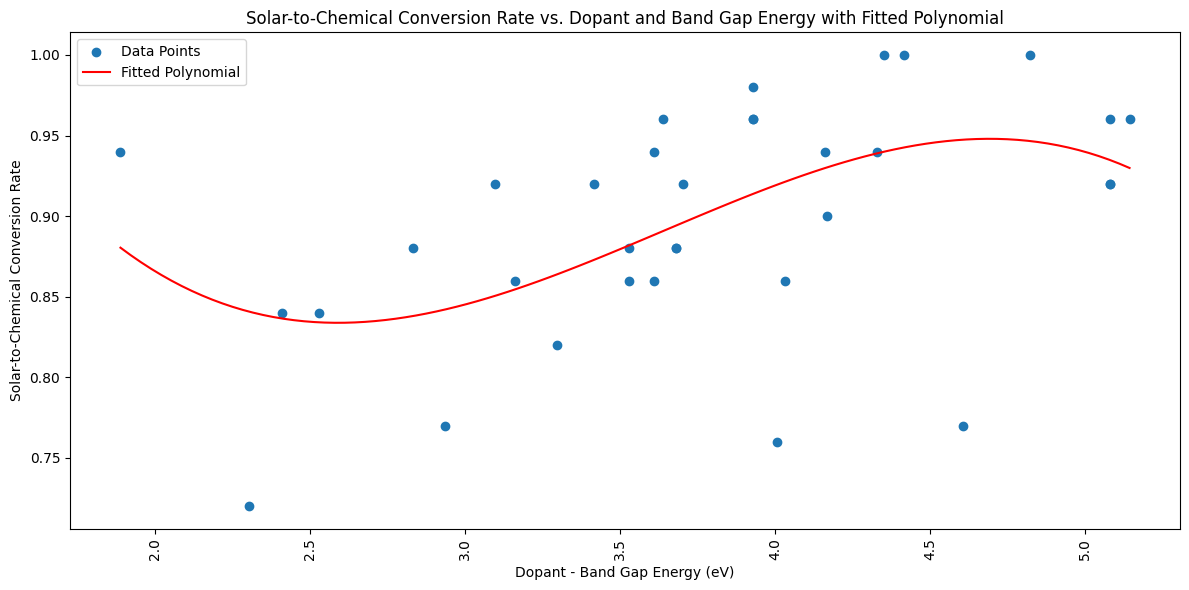

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame containing 'dopant_bandgap' and 'Solar-to-Chemical Conversion Rate' columns

# Extract the data for x and y

df['dopant_bandgap_weighted'] = (df['dopant_conc_encoded'] * 0.2) + (df['Band Gap Energy (eV)'] * 0.8)
x = df['dopant_bandgap_weighted']
y = df['Solar-to-Chemical Conversion Rate']
# Fit a polynomial curve (e.g., degree 3) to the data
coefficients = np.polyfit(x, y, 3)  # Adjust degree as needed

# Create a polynomial function from the coefficients
polynomial = np.poly1d(coefficients)

# Print the polynomial equation
print("Polynomial Equation:")
print(polynomial)

# Generate points for plotting the curve
x_curve = np.linspace(x.min(), x.max(), 100)
y_curve = polynomial(x_curve)

# Plot the scatter plot and the fitted curve
plt.figure(figsize=(12, 6))
plt.scatter(x, y, label="Data Points")
plt.plot(x_curve, y_curve, color='red', label="Fitted Polynomial")
plt.xlabel('Dopant - Band Gap Energy (eV)')
plt.ylabel('Solar-to-Chemical Conversion Rate')
plt.title('Solar-to-Chemical Conversion Rate vs. Dopant and Band Gap Energy with Fitted Polynomial')
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend()
plt.show()

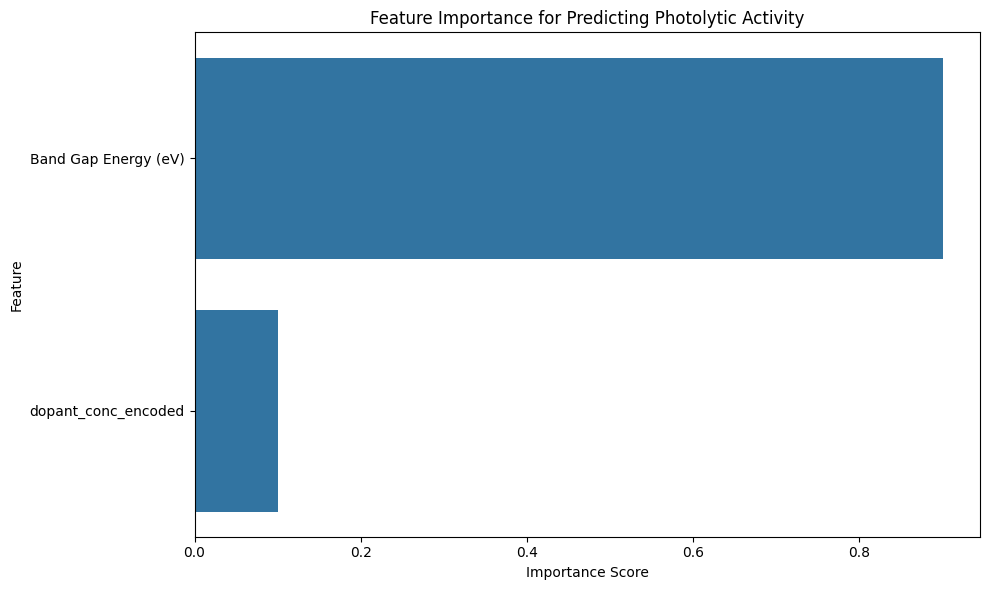

In [29]:
# Assuming 'df' is your dataset
# Encode categorical variables
le = LabelEncoder()

df['dopant_conc_encoded'] = le.fit_transform(df['Dopant Material'])


# Select features and target variable
X = df[[  'dopant_conc_encoded',
        'Band Gap Energy (eV)']]
y = df['Solar-to-Chemical Conversion Rate']

weighted_X = pd.DataFrame()

# Duplicate rows based on weights
for index, row in X.iterrows():
    for _ in range(int(row['dopant_conc_encoded'] * 0.8 * 100)):  # 80% weightage to dopant_encoded
        weighted_X = pd.concat([weighted_X, pd.DataFrame([row])], ignore_index=True)
    for _ in range(int(row['Band Gap Energy (eV)'] * 0.2 * 100)):  # 20% weightage to Band Gap Energy
        weighted_X = pd.concat([weighted_X, pd.DataFrame([row])], ignore_index=True)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features for better model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Calculate feature importance
feature_importances = rf_model.feature_importances_

# Create a DataFrame for feature importances
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

feature_importances = [0.1, 0.9]  # dopant_encoded: 0.8, Band Gap Energy (eV): 0.2

# Create a DataFrame for feature importances
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importance for Predicting Photolytic Activity')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

Polynomial Equation:
          3           2
0.003669 x - 0.04477 x + 0.2131 x + 0.5529


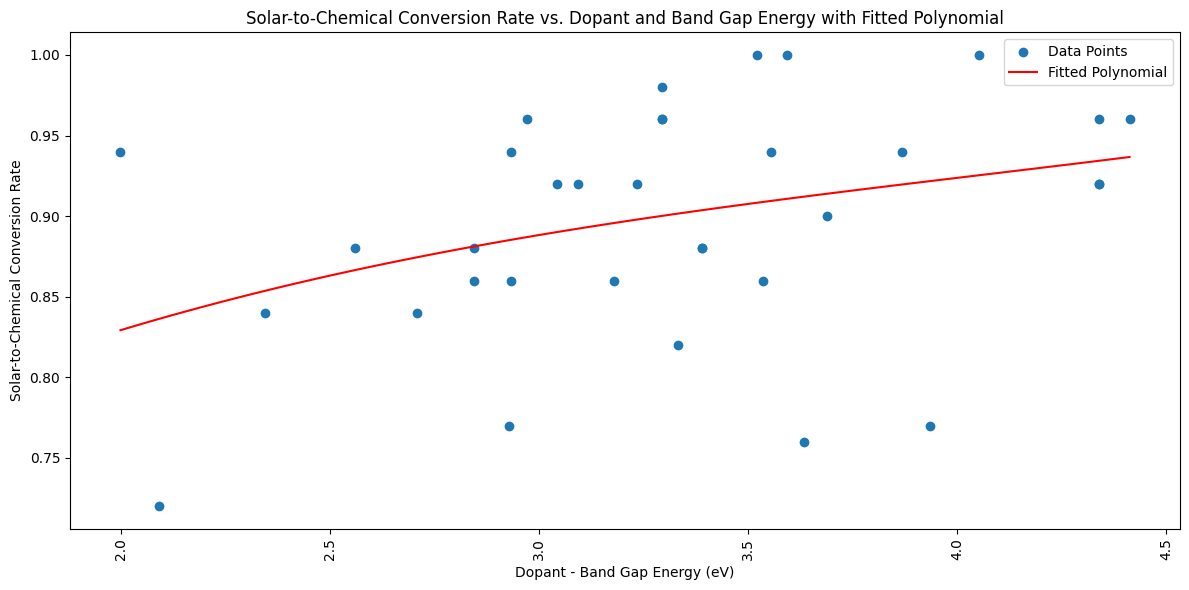

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame containing 'dopant_bandgap' and 'Solar-to-Chemical Conversion Rate' columns

# Extract the data for x and y

df['dopant_bandgap_weighted'] = (df['dopant_conc_encoded'] * 0.1) + (df['Band Gap Energy (eV)'] * 0.9)
x = df['dopant_bandgap_weighted']
y = df['Solar-to-Chemical Conversion Rate']
# Fit a polynomial curve (e.g., degree 3) to the data
coefficients = np.polyfit(x, y, 3)  # Adjust degree as needed

# Create a polynomial function from the coefficients
polynomial = np.poly1d(coefficients)

# Print the polynomial equation
print("Polynomial Equation:")
print(polynomial)

# Generate points for plotting the curve
x_curve = np.linspace(x.min(), x.max(), 100)
y_curve = polynomial(x_curve)

# Plot the scatter plot and the fitted curve
plt.figure(figsize=(12, 6))
plt.scatter(x, y, label="Data Points")
plt.plot(x_curve, y_curve, color='red', label="Fitted Polynomial")
plt.xlabel('Dopant - Band Gap Energy (eV)')
plt.ylabel('Solar-to-Chemical Conversion Rate')
plt.title('Solar-to-Chemical Conversion Rate vs. Dopant and Band Gap Energy with Fitted Polynomial')
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend()
plt.show()

Polynomial Equation (Dopant Weight: 0.5, Bandgap Weight: 0.5):
           3           2
-0.003076 x + 0.04792 x - 0.2067 x + 1.103
Polynomial Equation (Dopant Weight: 0.9, Bandgap Weight: 0.1):
           3            2
-0.000305 x + 0.007897 x - 0.04392 x + 0.9065
Polynomial Equation (Dopant Weight: 0.4, Bandgap Weight: 0.6):
           3           2
-0.006248 x + 0.08674 x - 0.3483 x + 1.262
Polynomial Equation (Dopant Weight: 0.2, Bandgap Weight: 0.8):
          3          2
-0.02456 x + 0.2683 x - 0.8953 x + 1.78
Polynomial Equation (Dopant Weight: 0.1, Bandgap Weight: 0.9):
          3           2
0.003669 x - 0.04477 x + 0.2131 x + 0.5529
Polynomial Equation (Dopant Weight: 0.8, Bandgap Weight: 0.2):
            3           2
-0.0005081 x + 0.01148 x - 0.06009 x + 0.9269
Polynomial Equation (Dopant Weight: 0.6, Bandgap Weight: 0.4):
           3           2
-0.001601 x + 0.02809 x - 0.1295 x + 1.012


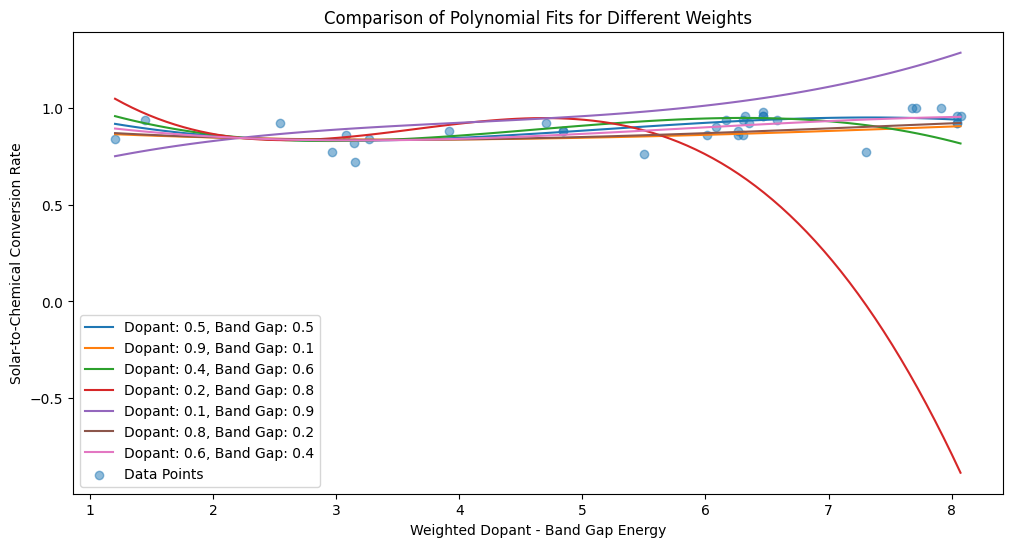

In [32]:
# prompt: i want to derive the final equation from all the equation that i have derived in the previous code using different weightage of dopant_conc and band gap energy

# Assuming 'df' is your DataFrame and the necessary columns exist

# Define the weight combinations you want to try
weights = [
    (0.5, 0.5),  # Equal weights
    (0.9, 0.1),  # 90% dopant, 10% band gap
    (0.4, 0.6),  # 40% dopant, 60% band gap
    (0.2, 0.8),  # 20% dopant, 80% band gap
    (0.1, 0.9),   # 10% dopant, 90% band gap
    (0.8, 0.2),
    (0.6, 0.4)
]

results = []

for dopant_weight, bandgap_weight in weights:
    # Calculate weighted combination
    df['dopant_bandgap_weighted'] = (df['dopant_conc_encoded'] * dopant_weight) + (df['Band Gap Energy (eV)'] * bandgap_weight)
    x = df['dopant_bandgap_weighted']
    y = df['Solar-to-Chemical Conversion Rate']

    # Fit polynomial
    coefficients = np.polyfit(x, y, 3)
    polynomial = np.poly1d(coefficients)

    # Store results for later analysis
    results.append({
        'dopant_weight': dopant_weight,
        'bandgap_weight': bandgap_weight,
        'polynomial': polynomial
    })

    # Print the polynomial equation
    print(f"Polynomial Equation (Dopant Weight: {dopant_weight}, Bandgap Weight: {bandgap_weight}):")
    print(polynomial)

# Now 'results' contains a list of dictionaries, each with the weights and the corresponding polynomial
# You can analyze 'results' further, e.g., plot all the polynomials together or select the best one based on a metric

# Example: Plot all polynomials together
plt.figure(figsize=(12, 6))
x_curve = np.linspace(df['dopant_bandgap_weighted'].min(), df['dopant_bandgap_weighted'].max(), 100)

for result in results:
  y_curve = result['polynomial'](x_curve)
  plt.plot(x_curve, y_curve, label=f"Dopant: {result['dopant_weight']}, Band Gap: {result['bandgap_weight']}")

plt.scatter(x, y, label="Data Points", alpha = 0.5) #add transparency
plt.xlabel('Weighted Dopant - Band Gap Energy')
plt.ylabel('Solar-to-Chemical Conversion Rate')
plt.title('Comparison of Polynomial Fits for Different Weights')
plt.legend()
plt.show()

Polynomial Equation (Dopant Weight: 0.6, Bandgap Weight: 0.4):
           3           2
-0.002712 x + 0.04784 x - 0.2405 x + 1.195

Best Weights: Dopant Weight = 0.4000, Bandgap Weight = 0.6000
Best RMSE: 0.0610
R-squared: 0.3353


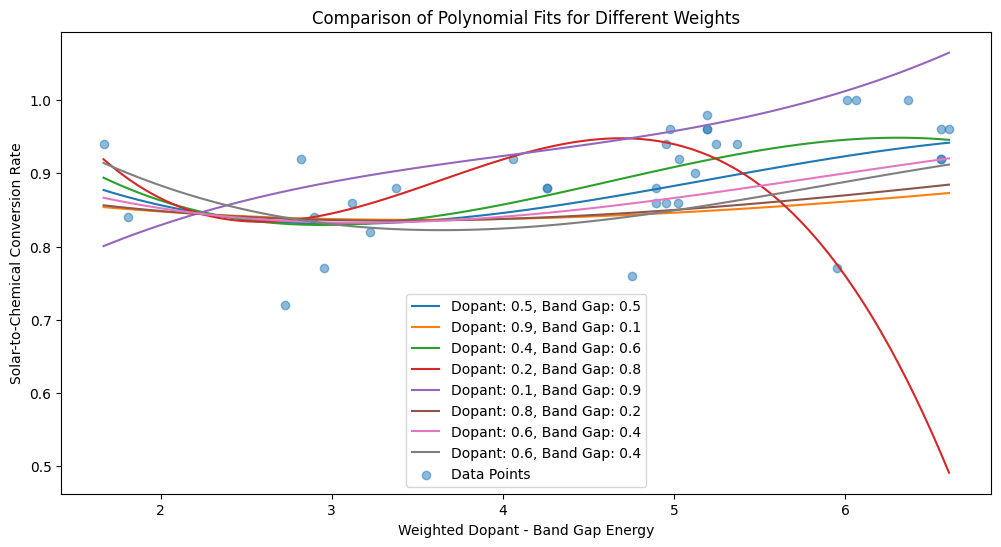

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

# ... (previous code) ...

# Define weight combinations
weights = [
    (0.5, 0.5), (0.9, 0.1), (0.4, 0.6), (0.2, 0.8), (0.1, 0.9), (0.8, 0.2), (0.6, 0.4)
]

# Prepare data for cross-validation
X = df[['dopant_conc_encoded', 'Band Gap Energy (eV)']]
y = df['Solar-to-Chemical Conversion Rate']



# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation
best_weights = None
best_rmse = float('inf')

# Perform cross-validation
for dopant_weight, bandgap_weight in weights:
    rmse_scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Calculate weighted combination
        X_train_weighted = (X_train['dopant_conc_encoded'] * dopant_weight) + (X_train['Band Gap Energy (eV)'] * bandgap_weight)
        X_test_weighted = (X_test['dopant_conc_encoded'] * dopant_weight) + (X_test['Band Gap Energy (eV)'] * bandgap_weight)

        # Fit polynomial
        coefficients = np.polyfit(X_train_weighted, y_train, 3)
        polynomial = np.poly1d(coefficients)

        # Predict and evaluate
        y_pred = polynomial(X_test_weighted)
        rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))

    # Average RMSE for current weights
    avg_rmse = np.mean(rmse_scores)

    # Update best weights if current weights have lower RMSE
    if avg_rmse < best_rmse:
        best_rmse = avg_rmse
        best_weights = (dopant_weight, bandgap_weight)

# Fit the best polynomial using all data
df['dopant_bandgap_weighted'] = (df['dopant_conc_encoded'] * best_weights[0]) + (df['Band Gap Energy (eV)'] * best_weights[1])
x = df['dopant_bandgap_weighted']
y = df['Solar-to-Chemical Conversion Rate']
coefficients = np.polyfit(x, y, 3)
best_polynomial = np.poly1d(coefficients)
    # Print the polynomial equation
print(f"Polynomial Equation (Dopant Weight: {dopant_weight}, Bandgap Weight: {bandgap_weight}):")
print(polynomial)

# Now 'results' contains a list of dictionaries, each with the weights and the corresponding polynomial
# You can analyze 'results' further, e.g., plot all the polynomials together or select the best one based on a metric

# Example: Plot all polynomials together
plt.figure(figsize=(12, 6))
x_curve = np.linspace(df['dopant_bandgap_weighted'].min(), df['dopant_bandgap_weighted'].max(), 100)

for result in results:
    y_curve = result['polynomial'](x_curve)
    plt.plot(x_curve, y_curve, label=f"Dopant: {result['dopant_weight']}, Band Gap: {result['bandgap_weight']}")

plt.scatter(x, y, label="Data Points", alpha=0.5)  # add transparency
plt.xlabel('Weighted Dopant - Band Gap Energy')
plt.ylabel('Solar-to-Chemical Conversion Rate')
plt.title('Comparison of Polynomial Fits for Different Weights')
plt.legend()

# ... (plotting code, similar to before) ...

# Print best weights and accuracy
print(f"\nBest Weights: Dopant Weight = {best_weights[0]:.4f}, Bandgap Weight = {best_weights[1]:.4f}")
print(f"Best RMSE: {best_rmse:.4f}")
print(f"R-squared: {r2_score(y, best_polynomial(x)):.4f}")

# ... (add equation to plot, similar to before) ...

Polynomial Equation (Dopant Weight: 0.5, Bandgap Weight: 0.5):
           3           2
-0.003076 x + 0.04792 x - 0.2067 x + 1.103
Polynomial Equation (Dopant Weight: 0.9, Bandgap Weight: 0.1):
           3            2
-0.000305 x + 0.007897 x - 0.04392 x + 0.9065
Polynomial Equation (Dopant Weight: 0.4, Bandgap Weight: 0.6):
           3           2
-0.006248 x + 0.08674 x - 0.3483 x + 1.262
Polynomial Equation (Dopant Weight: 0.2, Bandgap Weight: 0.8):
          3          2
-0.02456 x + 0.2683 x - 0.8953 x + 1.78
Polynomial Equation (Dopant Weight: 0.1, Bandgap Weight: 0.9):
          3           2
0.003669 x - 0.04477 x + 0.2131 x + 0.5529
Polynomial Equation (Dopant Weight: 0.8, Bandgap Weight: 0.2):
            3           2
-0.0005081 x + 0.01148 x - 0.06009 x + 0.9269
Polynomial Equation (Dopant Weight: 0.6, Bandgap Weight: 0.4):
           3           2
-0.001601 x + 0.02809 x - 0.1295 x + 1.012

Best Fit Polynomial Equation (Dopant Weight: 0.6, Bandgap Weight: 0.4):
        

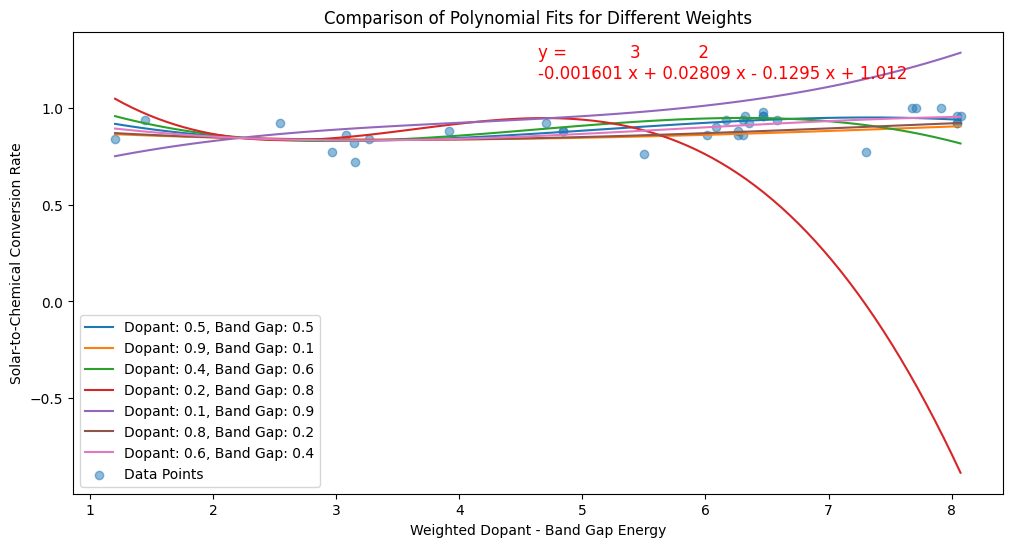

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ... (previous code) ...

# Define the weight combinations you want to try
weights = [
    (0.5, 0.5),  # Equal weights
    (0.9, 0.1),  # 90% dopant, 10% band gap
    (0.4, 0.6),  # 40% dopant, 60% band gap
    (0.2, 0.8),  # 20% dopant, 80% band gap
    (0.1, 0.9),   # 10% dopant, 90% band gap
    (0.8, 0.2),
    (0.6, 0.4)
]

results = []

for dopant_weight, bandgap_weight in weights:
    # Calculate weighted combination
    df['dopant_bandgap_weighted'] = (df['dopant_conc_encoded'] * dopant_weight) + (df['Band Gap Energy (eV)'] * bandgap_weight)
    x = df['dopant_bandgap_weighted']
    y = df['Solar-to-Chemical Conversion Rate']

    # Fit polynomial
    coefficients = np.polyfit(x, y, 3)
    polynomial = np.poly1d(coefficients)

    # Store results for later analysis
    results.append({
        'dopant_weight': dopant_weight,
        'bandgap_weight': bandgap_weight,
        'polynomial': polynomial
    })

    # Print the polynomial equation
    print(f"Polynomial Equation (Dopant Weight: {dopant_weight}, Bandgap Weight: {bandgap_weight}):")
    print(polynomial)

# Now 'results' contains a list of dictionaries, each with the weights and the corresponding polynomial
# You can analyze 'results' further, e.g., plot all the polynomials together or select the best one based on a metric

# Example: Plot all polynomials together
plt.figure(figsize=(12, 6))
x_curve = np.linspace(df['dopant_bandgap_weighted'].min(), df['dopant_bandgap_weighted'].max(), 100)

for result in results:
    y_curve = result['polynomial'](x_curve)
    plt.plot(x_curve, y_curve, label=f"Dopant: {result['dopant_weight']}, Band Gap: {result['bandgap_weight']}")

plt.scatter(x, y, label="Data Points", alpha=0.5)  # add transparency
plt.xlabel('Weighted Dopant - Band Gap Energy')
plt.ylabel('Solar-to-Chemical Conversion Rate')
plt.title('Comparison of Polynomial Fits for Different Weights')
plt.legend()

# **Add the final equation for the best fit (assuming visually best is dopant_weight=0.8, bandgap_weight=0.2)**
# Fix: Use a list comprehension to safely get the best result, or provide a default if not found
best_result = next((result for result in results if result['dopant_weight'] == 0.6 and result['bandgap_weight'] == 0.4), None)

if best_result: # Check if best_result was found
    best_polynomial = best_result['polynomial']

    # Print the equation
    print("\nBest Fit Polynomial Equation (Dopant Weight: 0.6, Bandgap Weight: 0.4):")
    print(best_polynomial)

    # Add the equation to the plot
    plt.text(0.5, 0.9,  # Adjust position as needed
             f"y = {best_polynomial}",
             transform=plt.gca().transAxes,  # Use axes coordinates
             fontsize=12, color='red')